In [1]:
#https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
#https://www.netpromoter.com/know/

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_selection import chi2
import numpy as np

import seaborn as sns

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

<b> Initial Loading </b>

In [5]:
df = pd.read_csv(r'\\e1001spss1\working area\Data Mining\Text Mining\NPS\NPS_res2_cleansed.csv',sep= ";" )

In [6]:
df.describe()

,Unnamed: 0,CST_CD,RESPONSE_ID,Score
count,9305.000000,9.305000e+03,9.305000e+03,9305.000000
mean,4652.000000,1.119307e+07,6.953722e+09,6.112628
std,2686.266461,2.298825e+07,1.662763e+07,3.563211
min,0.000000,3.540000e+02,6.884943e+09,0.000000
25%,2326.000000,1.426034e+06,6.945892e+09,3.000000
50%,4652.000000,3.794362e+06,6.957692e+09,7.000000
75%,6978.000000,6.076017e+06,6.966752e+09,10.000000
max,9304.000000,8.629256e+07,6.974752e+09,10.000000


In [7]:
def NPScorer (score):
        if score <7:
            NPS = '1. Detractor'
        elif score < 9:
            NPS = '2. Passive'
        else:
            NPS = '3. Promoter'
        return NPS        

<b> Data Cleansing </b>

In [8]:
df = df[pd.notnull(df['Translated_text'])]

In [9]:
df['NPS'] = df['Score'].apply(lambda x : NPScorer(x))

In [10]:
df['NPS_id'] = df['NPS'].factorize()[0]
NPS_id_df = df[['NPS', 'NPS_id']].drop_duplicates().sort_values('NPS_id')
NPS_to_id = dict(NPS_id_df.values)
id_to_NPS = dict(NPS_id_df[['NPS_id', 'NPS']].values)
df.head()

,Unnamed: 0,CST_CD,QUESTION_DATE,RESPONSE_ID,SURVEY_RECIPIENT_ID,Translated_text,Score,NPS,NPS_id
0,0,1290310,2018-11-02 00:00:00.0000000,6955188341,"1,25E+11",Some employees were rude and nervous towards m...,2,1. Detractor,0
1,1,4290125,2018-08-09 00:00:00.0000000,6926341210,33160694338,From the outset I have to say that your bank&#...,0,1. Detractor,0
2,2,6578482,2018-09-11 00:00:00.0000000,6938210437,25545794813,"I have been a customer since 2012, until recen...",2,1. Detractor,0
3,3,174088,2018-11-29 00:00:00.0000000,6963358618,68041937022,On 28-11-2018 I visited the OO42 PORTO CENTER ...,0,1. Detractor,0
4,4,4755997,2018-11-23 00:00:00.0000000,6961324439,72330762063,Due to employees. While the bank as an organiz...,1,1. Detractor,0


<b>Score Distribution </b>

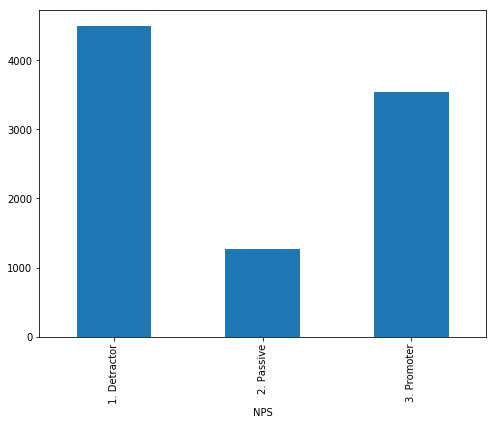

In [11]:
fig = plt.figure(figsize=(8,6))
df.groupby('NPS').Translated_text.count().plot.bar(ylim=0)
plt.show()

In [63]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='latin-1', ngram_range=(1,3), stop_words='english')

features = tfidf.fit_transform(df.Translated_text).toarray()
labels = df.NPS
features.shape


(9305, 1381)

In [64]:
N = 5
for NPS, NPS_id in sorted(NPS_to_id.items()):
    
    features_chi2 = chi2(features, labels == NPS)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    
    
    print("# '{}':".format(NPS))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))
    
    

# '1. Detractor':
  . Most correlated unigrams:
. friendly
. fast
. good
. excellent
. service
  . Most correlated bigrams:
. immediate service
. direct service
. fast service
. good service
. excellent service
  . Most correlated trigrams:
. direct friendly service
. direct service friendly
. good fast service
. long waiting time
. service friendly environment
# '2. Passive':
  . Most correlated unigrams:
. relatively
. faster
. improvement
. good
. room
  . Most correlated bigrams:
. fast service
. employees helpful
. good service
. faster service
. room improvement
  . Most correlated trigrams:
. good quick service
. service friendly environment
. service friendly staff
. good fast service
. good service employees
# '3. Promoter':
  . Most correlated unigrams:
. impeccable
. courtesy
. friendly
. service
. excellent
  . Most correlated bigrams:
. fast service
. immediate service
. good service
. direct service
. excellent service
  . Most correlated trigrams:
. service courtesy staf

<b>Naive Bayes Classifier</b>

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Translated_text'], df['NPS'], random_state = 0)
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [15]:
#Predict!
print(clf.predict(count_vect.transform(["I HAVE COOPERATION WITH YOUR COLOLETTE FOR A MORE YEAR .. AND I HAVE PAID THOUSANDS OF EURO IN TOLOS AND PANORAMICS AND WRITTEN LETTERS. THESE WAYS ARE WAITING TO BE CONTINUOUS !!!! SEE ALSO ALL COOPERATION WITH YOU ... THE COMPLAINTS WHICH HAVE RECORDED LONGLY ... AND MEET ME THAT YOU CAN DO TO REPLACE THE OPERATING OPINION I HAVE FOR YOU .. HERACLES OF HERAKLES Ξ.Ξ¦. Ξ37352480 .... PLEASE ANSWERED AND DO XANATOLMISI Collection AITAIRIA 2NOCHLISEI ..DIOTI WITH THE NEW LAW FOR TAPROSOPIKA MY DATA (AFTER YOU HAVE NOT gIVE PERMISSION FOR USE TO THIRD PARTY) WITH XANAENOCHLISEI .IDI THE CASE THE CHEIRIZETSI The DIKIGOROS ME, AND WILL FILL GOLD !!! I&#39;M WAITING FOR YOUR NEWS ."])))

['1. Detractor']


<b>Model Selection</b>

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]


In [17]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

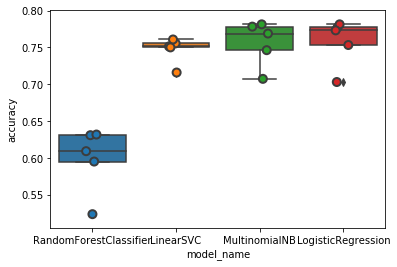

In [18]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [19]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.746700
LogisticRegression        0.757555
MultinomialNB             0.756371
RandomForestClassifier    0.598079
Name: accuracy, dtype: float64

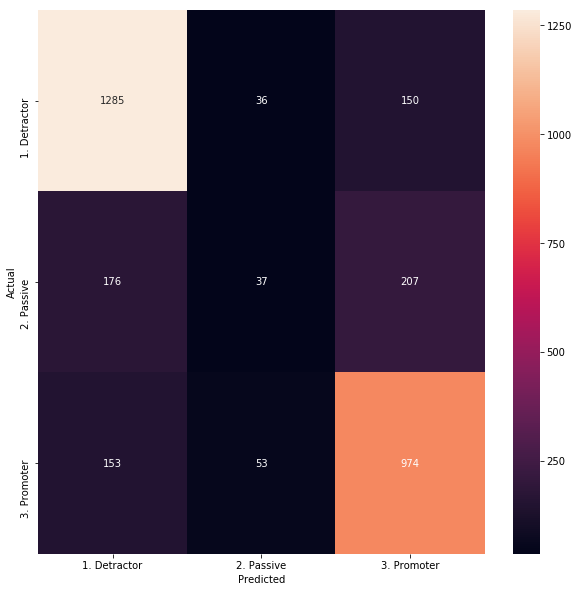

In [20]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=NPS_id_df.NPS.values, yticklabels=NPS_id_df.NPS.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [66]:
df.hea



0       Some employees were rude and nervous towards m...
1       From the outset I have to say that your bank&#...
2       I have been a customer since 2012, until recen...
3       On 28-11-2018 I visited the OO42 PORTO CENTER ...
4       Due to employees. While the bank as an organiz...
5       As for a formal issue such as the renewal of t...
7       The bad rating is for the incredible inconveni...
8       Thank you for your ability to give me an estim...
9       After my recent visit to the POS terminal I ha...
10      I have been trying for about 10 months to get ...
11      Unacceptable customer service. The employee wh...
12      Why are you looking for reasons and reasons no...
13      I am an American citizen of the Greek descent....
14      Thank you for giving me the opportunity to wri...
15      giati Why do we pay the interest on my card € ...
16      THE WORDS DO NOT HAVE TO DO WITH THE SHOP, FRO...
17      instead of building new businesses that are of...
18      They a